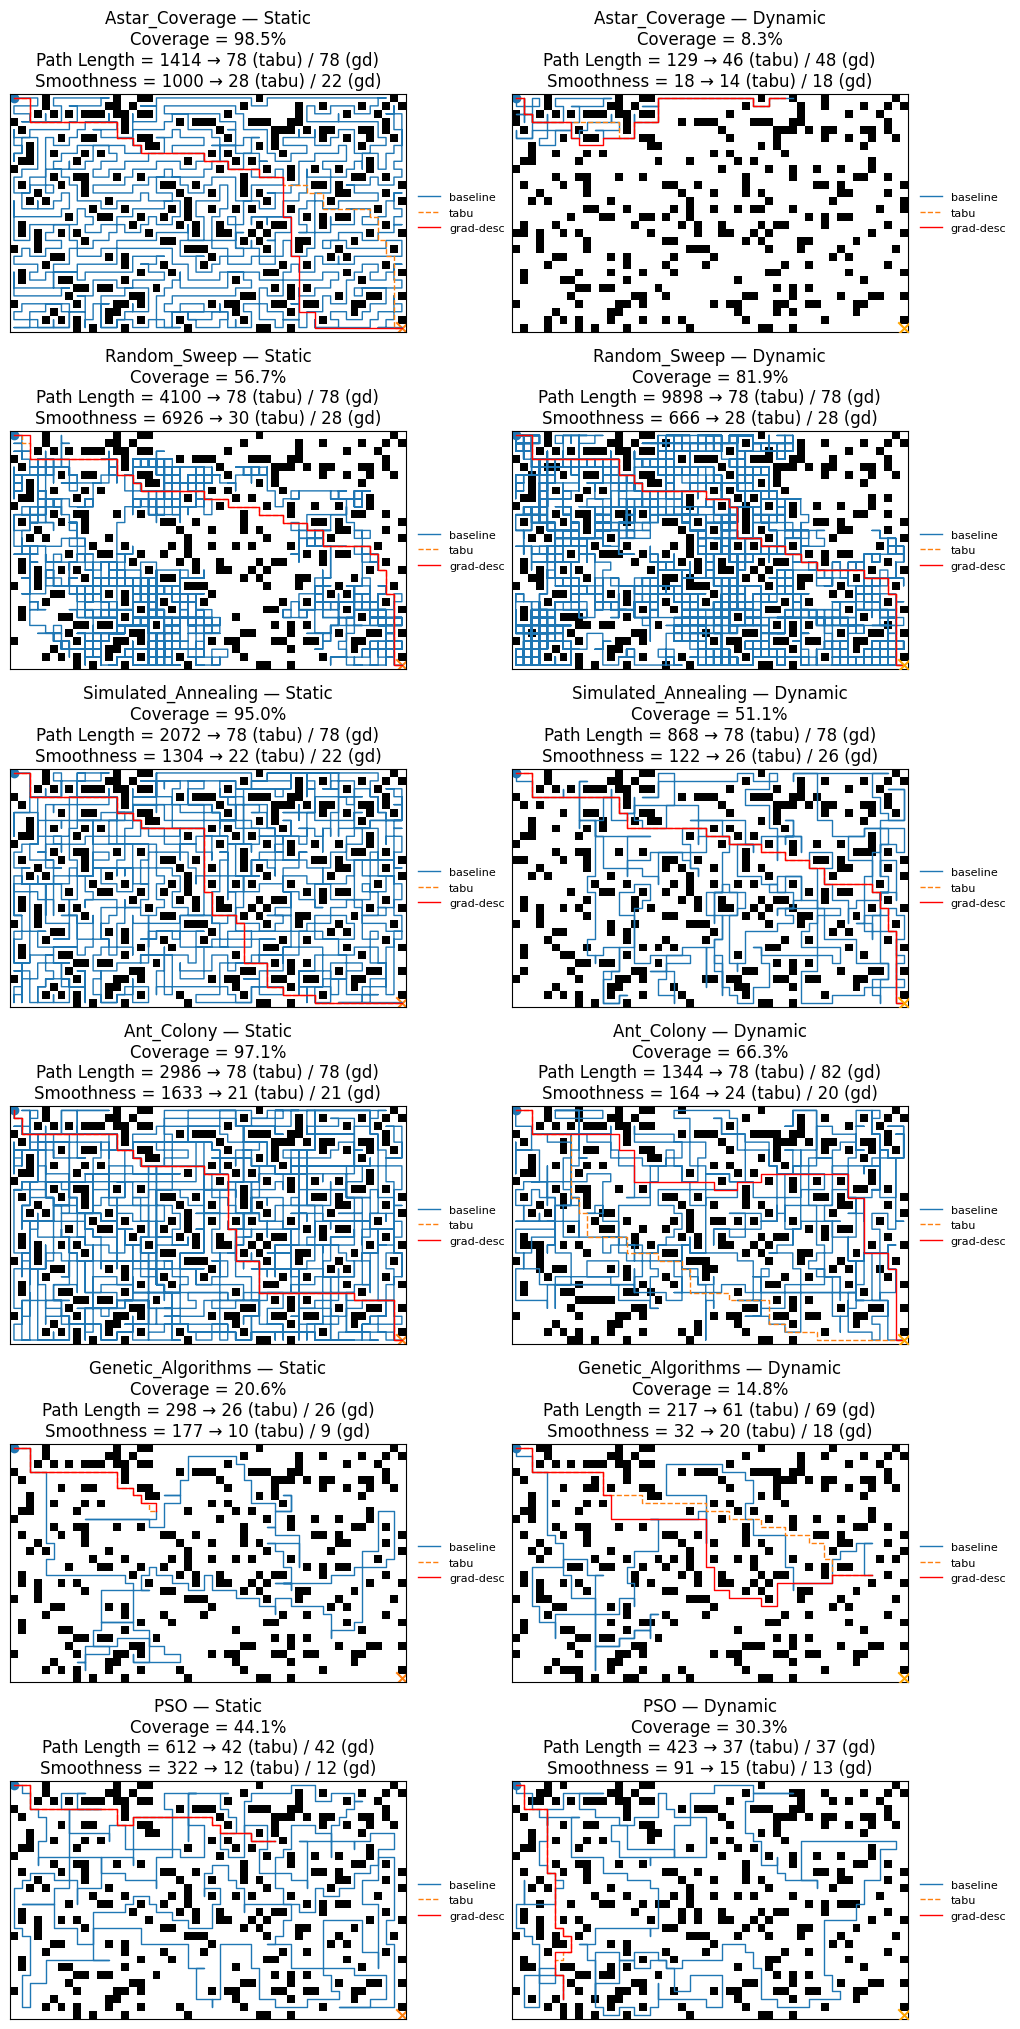


=== Static Results ===
Astar_Coverage         | Coverage= 98.46% | PathLength= 1414 | Overlap=  203 | Time= 0.409s | Energy=  1414 | ReachedGoal=True | TimeToGoal=0.409s
Random_Sweep           | Coverage= 56.70% | PathLength= 4100 | Overlap= 3403 | Time= 0.021s | Energy=  4100 | ReachedGoal=True | TimeToGoal=0.021s
Simulated_Annealing    | Coverage= 94.96% | PathLength= 2072 | Overlap=  904 | Time= 0.199s | Energy=  2072 | ReachedGoal=True | TimeToGoal=0.199s
Ant_Colony             | Coverage= 97.08% | PathLength= 2986 | Overlap= 1792 | Time= 0.229s | Energy=  2986 | ReachedGoal=True | TimeToGoal=0.229s
Genetic_Algorithms     | Coverage= 20.55% | PathLength=  298 | Overlap=   46 | Time= 5.072s | Energy=   298 | ReachedGoal=False | TimeToGoal=None
PSO                    | Coverage= 44.11% | PathLength=  612 | Overlap=   70 | Time= 5.002s | Energy=   612 | ReachedGoal=False | TimeToGoal=None

=== Dynamic Results ===
Astar_Coverage         | Coverage=  8.29% | PathLength=  129 | Overlap=

In [18]:
import math
import random
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Set, Dict
import heapq
# For Grid Representation
import numpy as np
import matplotlib.pyplot as plt

Coord = Tuple[int, int]


DYNAMIC_MOVE_PER_STEP = False   # How often cells move
COVERAGE_FINAL_STATE  = False   # Measures how much the the drone explored

# ----------GridWorld Class (The 2D Environment)----------

@dataclass
class GridWorld:
  width: int
  height: int
  ObstacleRatio: float = 0.15 # percentage of cells randomly set as static objects
  seed: int = 0
  DynamicObstacles: int = 0 # Number of moving obstacles
  DynamicMove_Prob: float = 0.2 # Probability that the object moves
  grid: np.ndarray = field(init=False)
  DynamicPositions: List[Coord] = field(default_factory=list) # List of Coordinates for dynamic obstacles
  # Added: fixed final goal for all algorithms
  Goal: Optional[Coord] = None

  # Creating Random Static Obstacles
  def __post_init__(self):
    RNG = random.Random(self.seed)
    self.grid = np.zeros((self.height, self.width), dtype=np.uint8)
    # Static obstacles
    NumberOf_Obstacles = int(self.width * self.height * self.ObstacleRatio)
    placed = 0
    while placed < NumberOf_Obstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0: # free
        self.grid[r, c] = 1  # static obstacle
        placed += 1

    self.grid[0, 0] = 0 # Start cell is always free

    # Dynamic obstacles
    self.DynamicPositions = []
    while len(self.DynamicPositions) < self.DynamicObstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0 and (r, c) not in self.DynamicPositions and (r, c) != (0,0):
        self.DynamicPositions.append((r,c))

    # Added: choose a fixed final goal (bottom-right), ensure it is free and not dynamic
    if self.Goal is None:
      self.Goal = (self.height - 1, self.width - 1)
    gr, gc = self.Goal
    self.grid[gr, gc] = 0
    self.DynamicPositions = [p for p in self.DynamicPositions if p != self.Goal]


  # --------Helper methods-------

  # Check if Coordinate is inside the grid
  def InBounds(self, p: Coord) -> bool:
    r, c = p
    return 0 <= r < self.height and 0 <= c < self.width

  # Checks if a cell is not an obstacle (dynamic or otherwise)
  def IsFree(self, p: Coord) -> bool:
    r, c = p
    if not self.InBounds(p):
      return False
    if self.grid[r, c] == 1:
      return False
    if p in self.DynamicPositions:
      return False
    return True

  # Returns the 4-connected neighbours (up, down left, right)
  def neighbors4(self, p: Coord) -> List[Coord]:
    r, c = p
    neighbor = [(r+1, c), (r-1, c), (r, c+1), (r, c-1)]
    return [q for q in neighbor if self.InBounds(q)]

  # Moves each dynamic obstacle randomly to an adjacent free cell with DynamicMove_Prob
  def StepForDynamic(self, RNG: random.Random):
    # FIX: prevent two obstacles taking the same new cell in the same tick
    NewPositions = []
    old = set(self.DynamicPositions)
    taken = set()  # reserve new cells this tick
    for position in self.DynamicPositions:
        newpos = position
        if RNG.random() < self.DynamicMove_Prob:
            candidates = [q for q in self.neighbors4(position)
                          if self.grid[q] == 0
                          and q not in old        # not someone’s old spot
                          and q not in taken      # not already taken this tick
                          and q != (0, 0)         # don't sit on start
                          and (self.Goal is None or q != self.Goal)]  # don't sit on goal
            if candidates:
                newpos = RNG.choice(candidates)
        NewPositions.append(newpos)
        taken.add(newpos)
    self.DynamicPositions = NewPositions


# --------- UAV Agent & Metrics -------------

# Represents the UAV
# Each move costs MoveCost Energy, and stops when BatteryCapacity is reached
@dataclass
class Agent:
  start: Coord = (0, 0)
  BatteryCapacity: int = 10_000 # Amount of "Energy units"
  MoveCost: int = 1
  path: List[Coord] = field(default_factory=lambda: [(0,0)])
  EnergyUsed: int = 0
# Returns the current positions
  def at(self) -> Coord:
    return self.path[-1]

# Checks if the agent still has enegry
  def CanMove(self) -> bool:
    return (self.EnergyUsed + self.MoveCost) <= self.BatteryCapacity

# Moves the UAV to the next cell, then updates the path and energy used
  def MoveTo(self, p:Coord):
    self.path.append(p)
    self.EnergyUsed += self.MoveCost

# Holds the performance data for a single simulation
@dataclass
class RunMetrics:
  CoveragePercentage: float # CoveragePercentage
  PathLength: int # Path Length
  OverlapCount: int # Overlap Count
  ExecutionTime: float # Execution Time
  EnergyUsed: int # Energy Used
  ReachedGoal: bool  # whether the goal was reached
  TimeToGoal: Optional[float] = None # Time the goal was reached


# ----------- Utilities -------------

def manhattan(a: Coord, b: Coord) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


# Part of Astar search, it's job is to rebuild the path from the start cell to the goal cell (lists path from start cell to goal cell)
def Rebuild_Path(From: Dict[Coord, Coord], goal: Coord) -> List[Coord]:
    current = goal
    rev = [current]
    while current in From:
        current = From[current]
        rev.append(current)
    rev.reverse()
    return rev


def Astar(grid: GridWorld, start: Coord, goal: Coord) -> Optional[List[Coord]]:
    if not grid.IsFree(start) or not grid.IsFree(goal):
        return None
    openh = []
    heapq.heappush(openh, (0 + manhattan(start, goal), 0, start))
    From: Dict[Coord, Coord] = {}
    g = {start: 0}
    visited = set()
    while openh:
        f, cost, current = heapq.heappop(openh)
        if current == goal:
            return Rebuild_Path(From, current)
        if current in visited:
            continue
        visited.add(current)
        for nb in grid.neighbors4(current):
            if not grid.IsFree(nb):
                continue
            newg = cost + 1
            if nb not in g or newg < g[nb]:
                g[nb] = newg
                From[nb] = current
                heapq.heappush(openh, (newg + manhattan(nb, goal), newg, nb))
    return None


# Helper to append a final A* leg to the fixed Goal
# NOTE: also updates 'visited' and 'overlap' so Coverage/Overlap are correct during this final leg.
def Append_Path_To_Goal(world: GridWorld, agent: Agent, RNG: random.Random, dynamic: bool,
                        Max_steps: int, t0: float, steps: int,
                        visited: Set[Coord],
                        overlap: int,
                        time_to_goal: Optional[float]) -> Tuple[int, int, Optional[float]]:
    if world.Goal is None:
        return steps, overlap, time_to_goal

    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        cur = agent.at()
        if cur == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break
        path = Astar(world, cur, world.Goal)
        if path is None or len(path) <= 1:
            break
        # Follow step-by-step, re-checking dynamics
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            steps += 1
            visited.add(nxt)
            if agent.at() == world.Goal:
                if time_to_goal is None:
                    time_to_goal = time.perf_counter() - t0
                break
        if agent.at() == world.Goal:
            break
        # If dynamic blocked, loop will replan next iteration
    return steps, overlap, time_to_goal


# ----------------------- Algorithms -------------------------

def Astar_Coverage(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()]) # keeps track of all visited cells
    overlap = 0 # counts revisited cells
    t0 = time.perf_counter() # record start time
    time_to_goal = None  # <-- track first reach time

    # Builds a mask for all free celss
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum()) # Total number of free cells

# Main loop: Keep looping until the agent still has battery, until the step count isn't exceeded and time doesn't run out
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

      # Find nearest unvisited target
        current = agent.at()
        # Stop early if we already reached the fixed final goal
        if world.Goal is not None and current == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break

        targets: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    targets.append((manhattan(current, p), p))
        if not targets:
            break
        targets.sort(key=lambda x: x[0])

        path = None
        for _, goal in targets[:500]:  # try nearest few
            path = Astar(world, current, goal)
            if path:
                break

        if not path:  # no reachable unvisited cell (blocked by obstacles/dynamics)
            break

        # Follow the path step-by-step
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                # Need to replan from current position
                break
            if not agent.CanMove():
                break # out of battery
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1
            if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
                break

    # Append a final leg to the common Goal for fair comparison
    steps, overlap, time_to_goal = Append_Path_To_Goal(world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal)

    t1 = time.perf_counter()
    # Coverage definition (toggle final-state option)
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    covered = len(visited)
    CoveragePercentage = 100.0 * covered / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedGoal=reached_goal,
        TimeToGoal=time_to_goal
    )


def RandomSweep(world: GridWorld, agent: Agent, seed: int = 0,
                 dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()
    time_to_goal = None  # <-- track first reach time

    Free_Mask = (world.grid == 0)
    Total_Free = int(Free_Mask.sum())

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # stop after 5 seconds
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        current = agent.at()
        # Stop if at final goal
        if world.Goal is not None and current == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break
        moves = [p for p in world.neighbors4(current) if world.IsFree(p)]
        if not moves:
            break
        nxt = RNG.choice(moves)
        if nxt in visited:
            overlap += 1
        agent.MoveTo(nxt)
        visited.add(nxt)
        steps += 1
        if dynamic and DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
            time_to_goal = time.perf_counter() - t0
            break
        if len(visited) >= Total_Free:
            break

    # Append a final leg to the common Goal
    steps, overlap, time_to_goal = Append_Path_To_Goal(world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal)

    t1 = time.perf_counter()
    # Coverage definition (toggle final-state option)
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(
        CoveragePercentage=CoveragePercentage,
        PathLength=len(agent.path)-1,
        OverlapCount=overlap,
        ExecutionTime=t1 - t0,
        EnergyUsed=agent.EnergyUsed,
        ReachedGoal=reached_goal,
        TimeToGoal=time_to_goal
    )


# Simulated Annealing

def SimulatedAnnealing(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])  # set of already visited cells
    overlap = 0                  # counts how many times agent revisits a cell
    t0 = time.perf_counter()     # measuring execution time
    time_to_goal = None          # <-- track first reach time

    # Build a mask of free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

    steps = 0
    T0, T_min, cooling = 5.0, 0.1, 0.995  # temperature parameters
    T = T0

    while agent.CanMove() and steps < Max_steps:  # loop until energy runs out or time expires
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        current = agent.at()
        # Stop if at final goal
        if world.Goal is not None and current == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break

        # gather candidate unvisited frontiers (nearest first)
        candidates: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    candidates.append((abs(r-current[0]) + abs(c-current[1]), p))

        if not candidates:
            break
        candidates.sort(key=lambda x: x[0])
        candidates = candidates[:200]  # limit scope

        # SA choice: softmin over distance with temperature
        dists = [max(1, d) for d, _ in candidates]
        weights = [math.exp(-d / max(T, 1e-6)) for d in dists]  # Boltzmann
        s = sum(weights)
        probs = [w / s for w in weights]

        # Sample one goal according to those probabilities
        rnum = RNG.random()
        cum = 0.0
        goal = candidates[0][1]
        for (d, p), pr in zip(candidates, probs):
            cum += pr
            if rnum <= cum:
                goal = p
                break

        # Use A* to traverse to the goal; if fails, try a few alternates
        path = Astar(world, current, goal)
        tries = 0
        while path is None and tries < 10 and candidates:
            goal = candidates[min(len(candidates)-1, RNG.randrange(len(candidates)))][1]
            path = Astar(world, current, goal)
            tries += 1
        if path is None:
            break

        # Path following
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1
            if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
                break

        T = max(T_min, T * cooling)  # cool down

    # Append a final leg to the common Goal
    steps, overlap, time_to_goal = Append_Path_To_Goal(
        world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal
    )

    # Returning Performance metrics
    t1 = time.perf_counter()
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, ReachedGoal=reached_goal, TimeToGoal=time_to_goal)




# Ant Colony Optimization

def AntColony(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Tracks visited cells, overlap count, and a start timer
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()
    time_to_goal = None  # <-- track first reach time

# Computes which cells are free
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

    pher = np.full_like(world.grid, 1.0, dtype=float)
    rho = 0.02     # evaporation
    alpha = 1.0    # pheromone weight
    beta = 2.0     # heuristic (1/distance) weight
    reward = 5.0   # deposit for newly covered cells

# Run until battery, step cap, or 5 second time limit is exceeded
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        current = agent.at()
        # Stop if at final goal
        if world.Goal is not None and current == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break

        # building candidate frontiers
        cand: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    cand.append((abs(r-current[0]) + abs(c-current[1]), p))
        if not cand:
            break
        cand.sort(key=lambda x: x[0])
        cand = cand[:200]
        numer = []
        for d, p in cand:
            d = max(1, d)
            tau = pher[p]
            eta = 1.0 / d
            numer.append((tau ** alpha) * (eta ** beta))
        s = sum(numer)

        # If all scores are zero pick the nearest, otherwise sample a goal proportional to its hueristic score
        if s == 0:
            goal = cand[0][1]
        else:
            rnum = RNG.random()
            cum = 0.0
            goal = cand[0][1]
            for (d, p), val in zip(cand, numer):
                cum += val / s
                if rnum <= cum:
                    goal = p
                    break

# Return to the chosen goal using Astar
        path = Astar(world, current, goal)
        tries = 0
        while path is None and tries < 10 and cand:
            # pick another candidate if current is unreachable
            goal = cand[min(len(cand)-1, RNG.randrange(len(cand)))][1] if cand else goal
            path = Astar(world, current, goal)
            tries += 1
        if path is None:
            # evaporate and continue
            pher *= (1.0 - rho)
            continue

# Execute the path & count new average
        newly = 0
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            else:
                newly += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1
            if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
                break

        # pheromone update
        pher *= (1.0 - rho)
        if newly > 0:
            pher[goal] += reward * newly

    # Append a final leg to the common Goal
    steps, overlap, time_to_goal = Append_Path_To_Goal(world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal)

# Computing final metrics
    t1 = time.perf_counter()
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, ReachedGoal=reached_goal, TimeToGoal=time_to_goal)


# Genetic Algorithm

def GeneticAlgorithm(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Setup
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()
    time_to_goal = None  # <-- track first reach time

# Marks all free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

# Finds unvisited free cells
    def frontier_list(cur: Coord) -> List[Coord]:
        L: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    L.append((abs(r-cur[0]) + abs(c-cur[1]), p))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

   # GA Parameters
    pop_size = 20
    seq_len = 5
    cx_rate = 0.7
    mut_rate = 0.3
    gens = 12

# UAV moves until its of energy, times out (5s) or step count is reached
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        cur = agent.at()
        # Stop if at final goal
        if world.Goal is not None and cur == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break

        fr = frontier_list(cur)
        if not fr:
            break

# creates a random sequence of 5 candidate goals
        def random_seq():
            return [fr[RNG.randrange(len(fr))] for _ in range(seq_len)]

# For each sequence it uses Astar to estimate the path length to each goal
        def fitness(seq: List[Coord]) -> float:
            pos = cur
            length = 0
            gain = 0
            for g in seq:
                path = Astar(world, pos, g)
                if path is None:
                    length += 1_000_000
                    continue
                length += len(path) - 1
                # estimate newly visited reward (heuristic)
                gain += 1.0 if g not in visited else 0.0
                pos = g
            # lower length and higher gain is better
            return length - 50.0 * gain

# GA evolution
        pop = [random_seq() for _ in range(pop_size)]
        for _ in range(gens):
            scores = [(fitness(ind), ind) for ind in pop]
            scores.sort(key=lambda x: x[0])
            elite = [ind for _, ind in scores[:max(2, pop_size // 5)]]
            new_pop = elite[:]
            while len(new_pop) < pop_size:
                if RNG.random() < cx_rate:
                    a = RNG.choice(elite)
                    b = RNG.choice(pop)
                    cut = RNG.randrange(1, seq_len)
                    child = a[:cut] + b[cut:]
                else:
                    child = RNG.choice(pop)[:]
                if RNG.random() < mut_rate:
                    idx = RNG.randrange(seq_len)
                    child[idx] = fr[RNG.randrange(len(fr))]
                new_pop.append(child)
            pop = new_pop

        # takes the best and execute its first waypoint
        best_seq = min(pop, key=fitness)
        goal = best_seq[0]
        path = Astar(world, cur, goal)
        if path is None:
            continue

       # Move UAV along the path
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1
            if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
                break

    # Append a final leg to the common Goal
    steps, overlap, time_to_goal = Append_Path_To_Goal(world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal)

# Return Metrics
    t1 = time.perf_counter()
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, ReachedGoal=reached_goal, TimeToGoal=time_to_goal)


# Particle Swarm Optimisation

def PSO(world: GridWorld, agent: Agent, seed: int = 0, dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:

  # Setup
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()
    time_to_goal = None  # <-- track first reach time

# Marks static free cells
    Free_Mask = np.zeros_like(world.grid, dtype=bool)
    for r in range(world.height):
        for c in range(world.width):
            if world.grid[r, c] == 0:
                Free_Mask[r, c] = True
    Total_Free = int(Free_Mask.sum())

# Builds list of of unvisted free cells
    def frontier(cur: Coord) -> List[Coord]:
        L: List[Tuple[int, Coord]] = []
        for r in range(world.height):
            for c in range(world.width):
                p = (r, c)
                if Free_Mask[r, c] and p not in visited:
                    L.append((abs(r-cur[0]) + abs(c-cur[1]), p))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

# Fitness function: If unreachable it gets a penalty, bonus for being in a locally unvisited neighbourhood
    def fitness(cur: Coord, goal: Coord) -> float:
        path = Astar(world, cur, goal)
        if path is None:
            return 1e9
        # prefer shorter route and goals in less-visited areas
        r, c = goal
        unv = 0
        for rr in range(max(0, r-1), min(world.height, r+2)):
            for cc in range(max(0, c-1), min(world.width, c+2)):
                if Free_Mask[rr, cc] and (rr, cc) not in visited:
                    unv += 1
        return (len(path) - 1) - 3.0 * unv

# Stops when out of energy, over the step cap, or past the 5 second limit
    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

# Initialise the Swarm
        cur = agent.at()
        # Stop if at final goal
        if world.Goal is not None and cur == world.Goal:
            if time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
            break

        F = frontier(cur)
        if not F:
            break
        swarm_size = min(25, max(5, len(F)//8))
        particles = [F[RNG.randrange(len(F))] for _ in range(swarm_size)]
        pbest = particles[:]
        pbest_fit = [fitness(cur, g) for g in pbest]
        gbest_idx = min(range(swarm_size), key=lambda i: pbest_fit[i])
        gbest = pbest[gbest_idx]

# After moving each particle, recompute fitness and update the personal best
        iters = 10
        for _ in range(iters):
            for i in range(swarm_size):
                # "velocity" proxy: jitter toward gbest by choosing a nearby frontier
                if RNG.random() < 0.6:
                    # pick among K nearest to gbest
                    gr, gc = gbest
                    neighs = sorted(F, key=lambda p: abs(p[0]-gr) + abs(p[1]-gc))[:20]
                    particles[i] = RNG.choice(neighs)
                else:
                    particles[i] = F[RNG.randrange(len(F))]
                fit = fitness(cur, particles[i])
                if fit < pbest_fit[i]:
                    pbest[i] = particles[i]
                    pbest_fit[i] = fit
            gbest_idx = min(range(swarm_size), key=lambda j: pbest_fit[j])
            gbest = pbest[gbest_idx]

# Execute the best found goal using Astar
        goal = gbest
        path = Astar(world, cur, goal)
        if path is None:
            continue
        for nxt in path[1:]:
            if dynamic and DYNAMIC_MOVE_PER_STEP:
                world.StepForDynamic(RNG)
            if dynamic and not world.IsFree(nxt):
                break
            if not agent.CanMove():
                break
            if nxt in visited:
                overlap += 1
            agent.MoveTo(nxt)
            visited.add(nxt)
            steps += 1
            if world.Goal is not None and agent.at() == world.Goal and time_to_goal is None:
                time_to_goal = time.perf_counter() - t0
                break

    # Append a final leg to the common Goal
    steps, overlap, time_to_goal = Append_Path_To_Goal(world, agent, RNG, dynamic, Max_steps, t0, steps, visited, overlap, time_to_goal)

# Computing metrics
    t1 = time.perf_counter()
    if COVERAGE_FINAL_STATE:
        Free_Mask_final = (world.grid == 0).copy()
        for rr, cc in world.DynamicPositions:
            Free_Mask_final[rr, cc] = False
        Total_Free = int(Free_Mask_final.sum())
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    reached_goal = (world.Goal is not None and agent.at() == world.Goal)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed, ReachedGoal=reached_goal, TimeToGoal=time_to_goal)


# ---------------- Path optimizers ----------------

# -------- Tabu Search path improver --------
def tabu_improve_path(world: GridWorld,
                      path: List[Coord],
                      time_limit: float = 0.75,
                      max_iters: int = 2000,
                      tabu_tenure: int = 25,
                      seed: int = 0) -> Tuple[List[Coord], Dict[str, int]]:

    RNG = random.Random(seed)

    # Quick guards
    if len(path) < 3:
        return path[:], {"iters": 0, "accepted": 0, "best_len": max(0, len(path)-1)}

    def path_len(pth: List[Coord]) -> int:
        return max(0, len(pth) - 1)

    def valid_consecutive(a: Coord, b: Coord) -> bool:
        # 4-connected neighbors
        return abs(a[0]-b[0]) + abs(a[1]-b[1]) == 1

    def feasible(pth: List[Coord]) -> bool:
        # cells must be free (given world's final state) & steps 4-connected
        for q in pth:
            if not world.IsFree(q):
                return False
        for u, v in zip(pth, pth[1:]):
            if not valid_consecutive(u, v):
                return False
        return True


    def edge(u: Coord, v: Coord) -> Tuple[Coord, Coord]:
        return (u, v)

    # Shortcut move: reconnect path[i] -> path[j] using A*
    def try_shortcut(cur_path: List[Coord], i: int, j: int) -> Optional[List[Coord]]:
        if j <= i + 1:  # nothing to shortcut
            return None
        a, b = cur_path[i], cur_path[j]
        new_leg = Astar(world, a, b)
        if not new_leg or len(new_leg) < 2:
            return None
        # splice: [..i] + new_leg[1:] + [j+1..]
        cand = cur_path[:i+1] + new_leg[1:] + cur_path[j+1:]
        return cand if feasible(cand) else None

    # Relocate/skip waypoint k: reconnect k-1 -> k+1 via A*
    def try_skip(cur_path: List[Coord], k: int) -> Optional[List[Coord]]:
        if k <= 0 or k >= len(cur_path) - 1:
            return None
        a, b = cur_path[k-1], cur_path[k+1]
        new_leg = Astar(world, a, b)
        if not new_leg or len(new_leg) < 2:
            return None
        cand = cur_path[:k] + new_leg[1:] + cur_path[k+1:]
        return cand if feasible(cand) else None

    best = path[:]
    best_val = path_len(best)
    cur = best[:]
    cur_val = best_val

    # Tabu list: recently removed edges with remaining tenure
    tabu: Dict[Tuple[Coord, Coord], int] = {}
    accepted = 0
    t_start = time.perf_counter()

    it = 0
    while it < max_iters and (time.perf_counter() - t_start) < time_limit:
        it += 1

        n = len(cur)
        if n < 3:
            # Nothing more to improve safely
            break

        # Decay tabu tenures (safe iteration)
        if tabu:
            to_del = []
            for e in list(tabu.keys()):
                tabu[e] -= 1
                if tabu[e] <= 0:
                    to_del.append(e)
            for e in to_del:
                del tabu[e]

        candidates = []

        # --- Shortcuts: generate only valid (i, j) with i+2 <= j < n
        if n >= 3:
            for _ in range(16):
                # pick i in [0, n-3] so i+2 <= n-1 exists
                i = RNG.randrange(0, n - 2)
                # bias to local windows but ensure a valid range
                if RNG.random() < 0.6:
                    j_min = i + 2
                    j_max = min(n - 1, i + 2 + RNG.randrange(6))
                    if j_min >= n:
                        continue
                    if j_max < j_min:
                        j_max = j_min
                    j = j_min if j_max == j_min else RNG.randrange(j_min, j_max + 1)
                else:
                    j_min = i + 2
                    if j_min >= n:
                        continue
                    j = RNG.randrange(j_min, n)
                cand = try_shortcut(cur, i, j)
                if cand:
                    removed = edge(cur[i], cur[i+1])
                    candidates.append(("shortcut", i, j, cand, removed))

        # --- Skips (only if there is an interior k)
        if n > 3:
            for _ in range(12):
                k = RNG.randrange(1, n - 1)
                cand = try_skip(cur, k)
                if cand:
                    removed = edge(cur[k-1], cur[k])
                    candidates.append(("skip", k, None, cand, removed))

        if not candidates:
            # No feasible local move found; stop early
            break

        # Pick best admissible candidate (tabu with aspiration)
        pick_idx = None
        pick_val = None
        pick = None
        for idx, (mtype, a, b, cand, removed_edge) in enumerate(candidates):
            val = path_len(cand)
            is_tabu = removed_edge in tabu
            if (not is_tabu) or (val < best_val):  # aspiration
                if pick_idx is None or val < pick_val:
                    pick_idx, pick_val, pick = idx, val, (mtype, a, b, cand, removed_edge)

        if pick is None:
            # everything tabu and not improving best -> mild diversification
            if tabu:
                for _ in range(min(3, len(tabu))):
                    tabu.pop(next(iter(tabu)))
            continue

        # Apply chosen move
        mtype, a, b, cand, removed_edge = pick
        cur = cand
        cur_val = path_len(cur)
        accepted += 1

        # Update tabu with removed edge
        tabu[removed_edge] = tabu_tenure

        # Update global best
        if cur_val < best_val:
            best = cur[:]
            best_val = cur_val

    info = {"iters": it, "accepted": accepted, "best_len": best_val}
    return best, info


# helper function for tabu (also reused by GD)
def repair_path_against_final(world: GridWorld, path: List[Coord]) -> List[Coord]:
    # Make the flown path feasible under the world's *current* occupancy (including DynamicPositions)
    if not path:
        return []
    repaired = [path[0]]
    i = 0
    while i < len(path) - 1:
        # advance j over the longest run of free nodes
        j = i + 1
        while j < len(path) and world.IsFree(path[j]):
            j += 1
        j -= 1  # now path[i..j] are free (at least j=i)
        # connect from current repaired tail to the farthest free waypoint
        a = repaired[-1]
        b = path[j]
        leg = Astar(world, a, b)
        if leg is None:
            # if cannot connect directly, step one ahead to try again
            if j == i:
                i += 1
            else:
                i = j
            continue
        repaired.extend(leg[1:])
        i = j + 1  # continue after the free stretch
    return repaired


# -------- Gradient Descent path improver (greedy local search) --------
def gradient_descent_improve_path(world: GridWorld,
                                  path: List[Coord],
                                  time_limit: float = 0.5,
                                  max_iters: int = 2000,
                                  seed: int = 0) -> Tuple[List[Coord], Dict[str, int]]:

    RNG = random.Random(seed)
    if len(path) < 3:
        return path[:], {"iters": 0, "accepted": 0, "best_len": max(0, len(path)-1)}

    def path_len(pth: List[Coord]) -> int:
        return max(0, len(pth) - 1)

    def valid_consecutive(a: Coord, b: Coord) -> bool:
        return abs(a[0]-b[0]) + abs(a[1]-b[1]) == 1

    def feasible(pth: List[Coord]) -> bool:
        for q in pth:
            if not world.IsFree(q):
                return False
        for u, v in zip(pth, pth[1:]):
            if not valid_consecutive(u, v):
                return False
        return True

    # --- New: smoothness metric ---
    # Smoothness is measured by:
    #   - the number of direction changes (turns)
    #   - an extra penalty for U-turns (immediate reversals)
    #   - a very small tie-breaker on overall length to avoid degenerate long paths

    def direction(u: Coord, v: Coord) -> Tuple[int, int]:
        return (v[0] - u[0], v[1] - u[1])

    def smoothness_score(pth: List[Coord]) -> float:
        if len(pth) < 2:
            return 0.0
        turns = 0
        uturns = 0
        prev_dir = direction(pth[0], pth[1])
        for a, b, c in zip(pth, pth[1:], pth[2:]):
            d1 = prev_dir
            d2 = direction(b, c)
            if d2 != d1:
                turns += 1
                # U-turn is exact reversal (e.g., (1,0) then (-1,0))
                if d2[0] == -d1[0] and d2[1] == -d1[1]:
                    uturns += 1
            prev_dir = d2
        L = path_len(pth)
        # Weights: emphasize smoothness; keep a tiny length regularizer
        w_turns = 1.0
        w_uturns = 3.0
        w_len   = 0.001
        return w_turns * turns + w_uturns * uturns + w_len * L

    def try_shortcut(cur_path: List[Coord], i: int, j: int) -> Optional[List[Coord]]:
        if j <= i + 1:
            return None
        a, b = cur_path[i], cur_path[j]
        new_leg = Astar(world, a, b)
        if not new_leg or len(new_leg) < 2:
            return None
        cand = cur_path[:i+1] + new_leg[1:] + cur_path[j+1:]
        return cand if feasible(cand) else None

    def try_skip(cur_path: List[Coord], k: int) -> Optional[List[Coord]]:
        if k <= 0 or k >= len(cur_path) - 1:
            return None
        a, b = cur_path[k-1], cur_path[k+1]
        new_leg = Astar(world, a, b)
        if not new_leg or len(new_leg) < 2:
            return None
        cand = cur_path[:k] + new_leg[1:] + cur_path[k+1:]
        return cand if feasible(cand) else None

    best = path[:]
    best_len_val = path_len(best)
    best_smooth_val = smoothness_score(best)
    t0 = time.perf_counter()
    accepted = 0
    it = 0

    while it < max_iters and (time.perf_counter() - t0) < time_limit:
        it += 1
        n = len(best)
        if n < 3:
            break

        improved = False
        current = best

        # Generate a small random neighborhood of candidates (mixed moves)
        candidates = []

        # Shortcuts
        if n >= 3:
            for _ in range(16):
                i = RNG.randrange(0, n - 2)
                # local window or global pick
                if RNG.random() < 0.6:
                    j_min = i + 2
                    j_max = min(n - 1, i + 2 + RNG.randrange(6))
                    if j_min >= n:
                        continue
                    if j_max < j_min:
                        j_max = j_min
                    j = j_min if j_max == j_min else RNG.randrange(j_min, j_max + 1)
                else:
                    j_min = i + 2
                    if j_min >= n:
                        continue
                    j = RNG.randrange(j_min, n)
                cand = try_shortcut(current, i, j)
                if cand:
                    candidates.append(cand)

        # Skips
        if n > 3:
            for _ in range(12):
                k = RNG.randrange(1, n - 1)
                cand = try_skip(current, k)
                if cand:
                    candidates.append(cand)

        # Evaluate and accept the best candidate by SMOOTHNESS (primary),
        # and break ties with (shorter) path length.
        pick = None
        pick_smooth = best_smooth_val
        pick_len = best_len_val
        for c in candidates:
            s = smoothness_score(c)
            l = path_len(c)
            if (s < pick_smooth) or (s == pick_smooth and l < pick_len):
                pick = c
                pick_smooth = s
                pick_len = l

        if pick is not None and (pick_smooth < best_smooth_val or (pick_smooth == best_smooth_val and pick_len < best_len_val)):
            best = pick
            best_smooth_val = pick_smooth
            best_len_val = pick_len
            accepted += 1
            improved = True

        if not improved:
            # No descent move found — stop
            break

    info = {
        "iters": it,
        "accepted": accepted,
        "best_len": best_len_val,      # kept for compatibility with existing prints
        "best_smooth": best_smooth_val # new: report final smoothness score
    }
    return best, info


# Function to visualise dynamic and static environments for each algorithm
def visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20,
                  seed=7):
    world_base = GridWorld(width=width, height=height,
                           ObstacleRatio=ObstacleRatio,
                           seed=seed,
                           DynamicObstacles=DynamicObstacles,
                           DynamicMove_Prob=0.25)

    # Algorithms
    Algs = {
        "Astar_Coverage": Astar_Coverage,
        "Random_Sweep": RandomSweep,
        "Simulated_Annealing": SimulatedAnnealing,
        "Ant_Colony": AntColony,
        "Genetic_Algorithms": GeneticAlgorithm,
        "PSO": PSO,
    }

    alg_names = list(Algs.keys())
    n_algs = len(alg_names)

    fig, axes = plt.subplots(n_algs, 2, figsize=(12, 3.4 * n_algs))
    if n_algs == 1:
        axes = np.array([axes])  # ensure 2D indexing

    # leave room on the right side so legends don't overlap the grid
    fig.subplots_adjust(right=0.86)

    # ---- helpers for summaries ----
    def path_len(pth: List[Coord]) -> int:
        return max(0, len(pth) - 1)

    # Same smoothness definition used by the GD optimizer:
    # turns (direction change) + 3 * u-turns (+ tiny length regularizer not needed for reporting)
    def _dir(u: Coord, v: Coord) -> Tuple[int, int]:
        return (v[0] - u[0], v[1] - u[1])

    def smoothness_score(pth: List[Coord]) -> int:
        if len(pth) < 3:
            return 0
        turns = 0
        uturns = 0
        d_prev = _dir(pth[0], pth[1])
        for a, b, c in zip(pth, pth[1:], pth[2:]):
            d_next = _dir(b, c)
            if d_next != d_prev:
                turns += 1
                if d_next[0] == -d_prev[0] and d_next[1] == -d_prev[1]:
                    uturns += 1
            d_prev = d_next
        # weight u-turns more heavily to reflect harsher curvature
        return turns + 3 * uturns

    results_static: Dict[str, RunMetrics] = {}
    results_dynamic: Dict[str, RunMetrics] = {}

    # Hold per-algo optimizer summaries
    opt_len_static_tabu: Dict[str, Tuple[int,int,int]] = {}   # (before, after, delta)
    opt_len_dynamic_tabu: Dict[str, Tuple[int,int,int]] = {}
    opt_len_static_gd: Dict[str, Tuple[int,int,int]] = {}
    opt_len_dynamic_gd: Dict[str, Tuple[int,int,int]] = {}

    # NEW: smoothness summaries
    opt_smooth_static_tabu: Dict[str, Tuple[int,int,int]] = {}
    opt_smooth_dynamic_tabu: Dict[str, Tuple[int,int,int]] = {}
    opt_smooth_static_gd: Dict[str, Tuple[int,int,int]] = {}
    opt_smooth_dynamic_gd: Dict[str, Tuple[int,int,int]] = {}

    for i, (name, fn) in enumerate(Algs.items()):

        # ---- Static run ----
        agent_s = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_s = GridWorld(width=world_base.width, height=world_base.height,
                            ObstacleRatio=0.0, seed=seed,
                            DynamicObstacles=0,
                            DynamicMove_Prob=world_base.DynamicMove_Prob,
                            Goal=world_base.Goal) # keep the SAME goal
        world_s.grid = world_base.grid.copy()
        world_s.DynamicPositions = []

        met_s = fn(world_s, agent_s, seed=seed, dynamic=False)
        results_static[name] = met_s

        # --- Optimize (STATIC) ---
        before_s = agent_s.path[:]  # keep original
        # Tabu
        opt_s_tabu, _ = tabu_improve_path(world_s, before_s, time_limit=0.5, seed=seed)
        before_len_s = path_len(before_s)
        after_len_s_tabu  = path_len(opt_s_tabu)
        opt_len_static_tabu[name] = (before_len_s, after_len_s_tabu, before_len_s - after_len_s_tabu)
        # Gradient Descent
        opt_s_gd, _ = gradient_descent_improve_path(world_s, before_s, time_limit=0.5, seed=seed)
        after_len_s_gd = path_len(opt_s_gd)
        opt_len_static_gd[name] = (before_len_s, after_len_s_gd, before_len_s - after_len_s_gd)

        # NEW: smoothness stats (STATIC)
        before_sm_s = smoothness_score(before_s)
        after_sm_s_tabu = smoothness_score(opt_s_tabu)
        after_sm_s_gd   = smoothness_score(opt_s_gd)
        opt_smooth_static_tabu[name] = (before_sm_s, after_sm_s_tabu, before_sm_s - after_sm_s_tabu)
        opt_smooth_static_gd[name]   = (before_sm_s, after_sm_s_gd,   before_sm_s - after_sm_s_gd)

        ax_s = axes[i, 0]
        img_s = np.where(world_s.grid == 1, 0.2, 1.0)
        ax_s.imshow(img_s, cmap="gray", origin="upper",
                    interpolation="nearest",
                    extent=(-0.5, world_s.width-0.5, world_s.height-0.5, -0.5))
        ys = [p[0] for p in agent_s.path]
        xs = [p[1] for p in agent_s.path]
        ax_s.plot(xs, ys, linewidth=1.0, label="baseline")
        # overlay optimized path (Tabu dashed)
        ys_tabu = [p[0] for p in opt_s_tabu]
        xs_tabu = [p[1] for p in opt_s_tabu]
        ax_s.plot(xs_tabu, ys_tabu, linewidth=1.0, linestyle="--", label="tabu")
        # overlay gradient descent (red line)
        ys_gd = [p[0] for p in opt_s_gd]
        xs_gd = [p[1] for p in opt_s_gd]
        ax_s.plot(xs_gd, ys_gd, linewidth=1.0, color="red", label="grad-desc")
        ax_s.scatter([agent_s.path[0][1]], [agent_s.path[0][0]], marker="o")
        if world_s.Goal is not None:
            ax_s.scatter([world_s.Goal[1]], [world_s.Goal[0]], marker="x", s=80)

        ax_s.set_title(
            f"{name} — Static\n"
            f"Coverage = {met_s.CoveragePercentage:.1f}%\n"
            f"Path Length = {met_s.PathLength} → {after_len_s_tabu} (tabu) / {after_len_s_gd} (gd)\n"
            f"Smoothness = {before_sm_s} → {after_sm_s_tabu} (tabu) / {after_sm_s_gd} (gd)"
        )
        ax_s.set_xticks([]); ax_s.set_yticks([])
        ax_s.set_aspect('equal')
        # move legend outside the axes
        ax_s.legend(loc="center left", bbox_to_anchor=(1.005, 0.5),
                    fontsize=8, frameon=False)

        # ---- Dynamic run ----
        agent_d = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_d = GridWorld(width=world_base.width, height=world_base.height,
                            ObstacleRatio=0.0, seed=seed,
                            DynamicObstacles=world_base.DynamicObstacles,
                            DynamicMove_Prob=world_base.DynamicMove_Prob,
                            Goal=world_base.Goal)  # <-- pass the SAME goal
        world_d.grid = world_base.grid.copy()
        world_d.DynamicPositions = list(world_base.DynamicPositions)

        met_d = fn(world_d, agent_d, seed=seed, dynamic=True)
        results_dynamic[name] = met_d

        # --- Optimize (DYNAMIC) ---
        before_d = agent_d.path[:]
        # Option: repair the flown path *against the final world state* first
        repaired_d = repair_path_against_final(world_d, before_d)
        # Tabu
        opt_d_tabu, _ = tabu_improve_path(world_d, repaired_d, time_limit=0.5, seed=seed)
        before_len_d = path_len(repaired_d)
        after_len_d_tabu  = path_len(opt_d_tabu)
        opt_len_dynamic_tabu[name] = (before_len_d, after_len_d_tabu, before_len_d - after_len_d_tabu)
        # Gradient Descent
        opt_d_gd, _ = gradient_descent_improve_path(world_d, repaired_d, time_limit=0.5, seed=seed)
        after_len_d_gd = path_len(opt_d_gd)
        opt_len_dynamic_gd[name] = (before_len_d, after_len_d_gd, before_len_d - after_len_d_gd)

        # NEW: smoothness stats (DYNAMIC)
        before_sm_d = smoothness_score(repaired_d)
        after_sm_d_tabu = smoothness_score(opt_d_tabu)
        after_sm_d_gd   = smoothness_score(opt_d_gd)
        opt_smooth_dynamic_tabu[name] = (before_sm_d, after_sm_d_tabu, before_sm_d - after_sm_d_tabu)
        opt_smooth_dynamic_gd[name]   = (before_sm_d, after_sm_d_gd,   before_sm_d - after_sm_d_gd)

        # Build a visualization grid where BOTH static and the FINAL dynamic
        # obstacle positions are drawn as black cells (value=1)
        vis_grid = world_d.grid.copy()
        for (rr, cc) in world_d.DynamicPositions:
            vis_grid[rr, cc] = 1  # paint dynamic obstacles black

        ax_d = axes[i, 1]
        img_d = np.where(vis_grid == 1, 0.2, 1.0)
        ax_d.imshow(img_d, cmap="gray", origin="upper",
                    interpolation="nearest",
                    extent=(-0.5, world_d.width-0.5, world_d.height-0.5, -0.5))

        yd = [p[0] for p in agent_d.path]
        xd = [p[1] for p in agent_d.path]
        ax_d.plot(xd, yd, linewidth=1.0, label="baseline")
        # overlay optimized path (Tabu dashed)
        yd_tabu = [p[0] for p in opt_d_tabu]
        xd_tabu = [p[1] for p in opt_d_tabu]
        ax_d.plot(xd_tabu, yd_tabu, linewidth=1.0, linestyle="--", label="tabu")
        # overlay gradient descent (red line)
        yd_gd = [p[0] for p in opt_d_gd]
        xd_gd = [p[1] for p in opt_d_gd]
        ax_d.plot(xd_gd, yd_gd, linewidth=1.0, color="red", label="grad-desc")

        # start marker
        ax_d.scatter([agent_d.path[0][1]], [agent_d.path[0][0]], marker="o")

        # GOAL marker
        if hasattr(world_d, "Goal") and world_d.Goal is not None:
            ax_d.scatter([world_d.Goal[1]], [world_d.Goal[0]],
                         marker="x", s=80, color="orange", zorder=5)

        ax_d.set_title(
            f"{name} — Dynamic\n"
            f"Coverage = {met_d.CoveragePercentage:.1f}%\n"
            f"Path Length = {met_d.PathLength} → {after_len_d_tabu} (tabu) / {after_len_d_gd} (gd)\n"
            f"Smoothness = {before_sm_d} → {after_sm_d_tabu} (tabu) / {after_sm_d_gd} (gd)"
        )
        ax_d.set_xticks([]); ax_d.set_yticks([])
        ax_d.set_aspect('equal')
        # move legend outside the axes
        ax_d.legend(loc="center left", bbox_to_anchor=(1.005, 0.5),
                    fontsize=8, frameon=False)

    # keep tight layout but preserve the right margin for legends
    plt.tight_layout(rect=(0, 0, 0.86, 1))
    plt.show()

    # ---------- Raw performance tables ----------
    print("\n=== Static Results ===")
    for k, m in results_static.items():
        print(f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
              f"PathLength={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
              f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d} | "
              f"ReachedGoal={m.ReachedGoal} | "
              f"TimeToGoal={('%.3fs' % m.TimeToGoal) if m.TimeToGoal is not None else 'None'}")

    print("\n=== Dynamic Results ===")
    for k, m in results_dynamic.items():
        print(f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
              f"PathLength={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
              f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d} | "
              f"ReachedGoal={m.ReachedGoal} | "
              f"TimeToGoal={('%.3fs' % m.TimeToGoal) if m.TimeToGoal is not None else 'None'}")

    # ---------- Combined optimizer summaries (length + smoothness together) ----------
    def print_combined(title, len_dict, sm_dict):
        print(f"\n=== {title} ===")
        for k in alg_names:
            if k in len_dict and k in sm_dict:
                lb, la, ld = len_dict[k]
                sb, sa, sd = sm_dict[k]
                lred = (100.0 * ld / lb) if lb > 0 else 0.0
                sred = (100.0 * sd / sb) if sb > 0 else 0.0
                print(f"{k:22s} | Path Length {lb:5d}→{la:5d} Difference={ld:4d} ({lred:5.1f}%) | "
                      f"Smoothness {sb:5d}→{sa:5d} Difference={sd:4d} ({sred:5.1f}%)")

    print_combined("Tabu — Static",   opt_len_static_tabu,   opt_smooth_static_tabu)
    print_combined("Tabu — Dynamic",  opt_len_dynamic_tabu,  opt_smooth_dynamic_tabu)
    print_combined("Grad-Descent — Static",  opt_len_static_gd,  opt_smooth_static_gd)
    print_combined("Grad-Descent — Dynamic", opt_len_dynamic_gd, opt_smooth_dynamic_gd)




if __name__ == "__main__":
    visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20, seed=7)
